# Synthetic dataset generation visualization

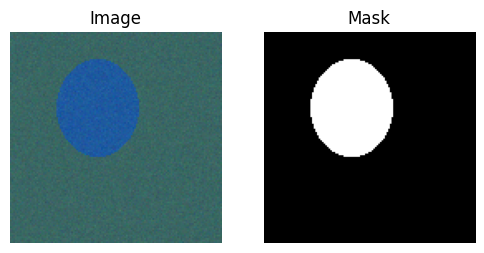

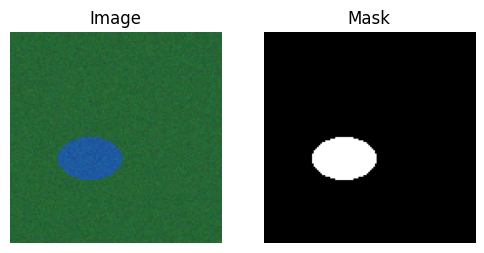

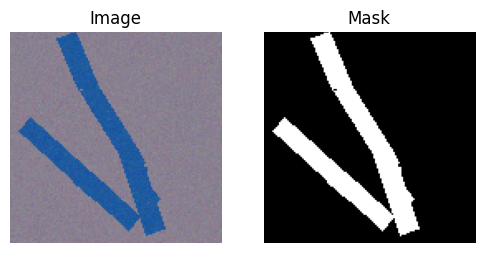

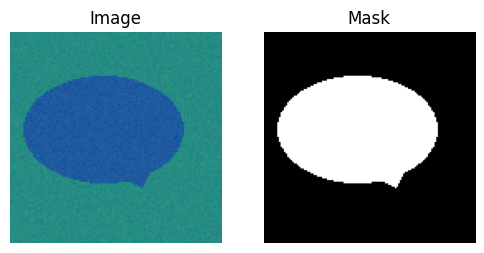

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), ".."))
sys.path.append(PROJECT_ROOT)

from data.dataset import SyntheticFloodDataset


def unnormalize(img_tensor):
    # img_tensor: [3,H,W] normalized with ImageNet mean/std
    mean = np.array([0.485,0.456,0.406])
    std  = np.array([0.229,0.224,0.225])
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

if __name__ == '__main__':
    ds = SyntheticFloodDataset(length=8, size=128, pre_generate=True, seed=42)
    for i in range(4):
        img, mask = ds[i]
        img_np = unnormalize(img)
        mask_np = mask.squeeze(0).cpu().numpy()

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1); plt.imshow(img_np); plt.title('Image'); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(mask_np, cmap='gray'); plt.title('Mask'); plt.axis('off')
        plt.show()


# Test visualization

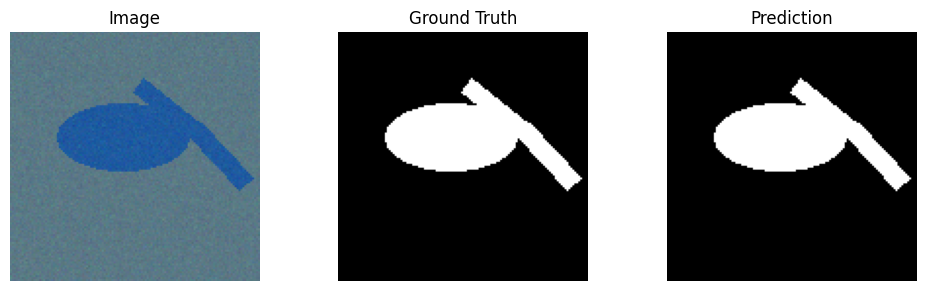

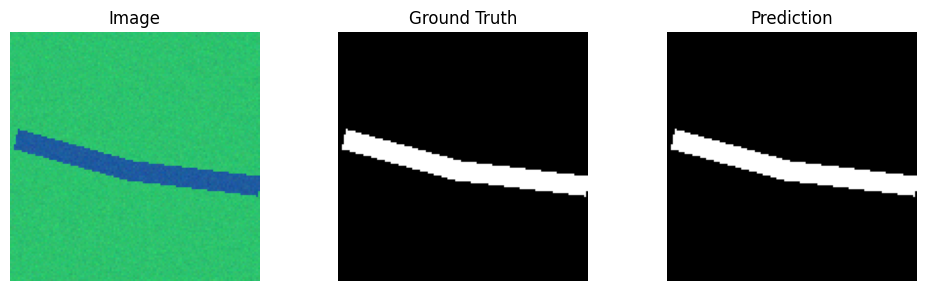

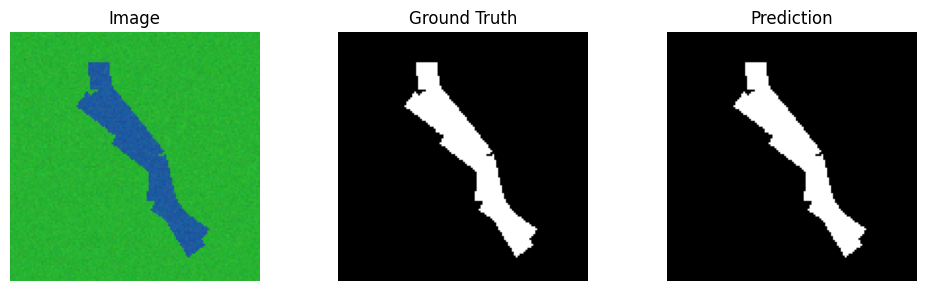

In [8]:
from model import UNetSmall
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), ".."))
sys.path.append(PROJECT_ROOT)

from data.dataset import SyntheticFloodDataset

# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform_img = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_ds = SyntheticFloodDataset(length=5, size=128, img_transform=transform_img) 
model = UNetSmall(3, 1, 32).to(device)

# Fix: Use full path to model file
model_path = os.path.join(PROJECT_ROOT, "best_unet.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# plot predictions
for i in range(3):
    img, mask = test_ds[i]
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(device))).cpu().squeeze().numpy()

    # Fix: Need to denormalize the image for proper visualization
    img_display = img.clone()
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = img_display * std + mean
    img_display = torch.clamp(img_display, 0, 1)  # Ensure valid range

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img_display.permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()